[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

## Download Kaggle Data

Uncomment the below function to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [358]:
def download_kaggle_data():
    from google.colab import userdata
    import os
    
    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    
    !kaggle competitions download -c store-sales-time-series-forecasting
    
    ! unzip "store-sales-time-series-forecasting.zip" -d data

# download_kaggle_data()

In [359]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')

## Datasets

The datasets provided by Kaggle include: 

* **train.csv**
* **test.csv**
* **transactions.csv**
* **stores.csv**
* **holiday_events.csv**
* **oil.csv**


**Additional Notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Features:

* *date*: Date of entry
* *store_nbr*: Store Number
* *family*: Product Family
* *onpromotion*: Items in a product family being promoted at a store at a given date.
* *sales (Target variable)*: Total sales for a product family at a particular store at a given date.
* *cluster*: Grouping of similar stores
* *type*: Type of Store
* *city*: City
* *state*: State the store is located in
* *holiday_type & locale* : If it was a holiday and type of holiday
* *transactions*: Number of transactions

In [360]:
# Dtype for loading datasets
dtype = {
    'store_nbr': 'int64',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}


# Part 1: Exploratory Data Analysis (EDA)

The data will be explored by datasets, transformations if any will be applied after understanding the imported information.

## 1. `store_sales` 

 Dataset: **train.csv**
 
The training data, comprising time series of features. Columns include:

- **store_nbr** - identifies the 54 different stores at which the products are being sold at.
- **family** - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- **onpromotion** - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- **sales (target)** - describes the total sales per product family at a given store on a given date. to ...

In [361]:
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [362]:
# dataset overview
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(1), datetime64[ns](1), float32(1), int64(2), uint64(1)
memory usage: 105.9 MB


In [363]:
store_sales.describe()

id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088384  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662819e+05                            NaN  1.558579e+01   

              sales   onpromotion  
count  3.000888e+06  3.000888e+06  
mean   3.577758e+02  2.602770e+00  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    1.100000e+01  0.000000e+00  
75%    1.958473e+02  0.000000e+00  
max    1.247170e+05  7.410000e+02  
std    1.101998e+03  1.221888e+01

In [364]:
# Check for missing values
store_sales.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [365]:
# What's the time range?
store_sales["date"]

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, Length: 3000888, dtype: datetime64[ns]

In [366]:
# How many stores?
store_sales["store_nbr"].nunique()

54

In [367]:
store_sales["store_nbr"].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [368]:
# How many family classes?
store_sales["family"].nunique(), store_sales["family"].unique()

(33,
 ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
 Length: 33
 Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'])

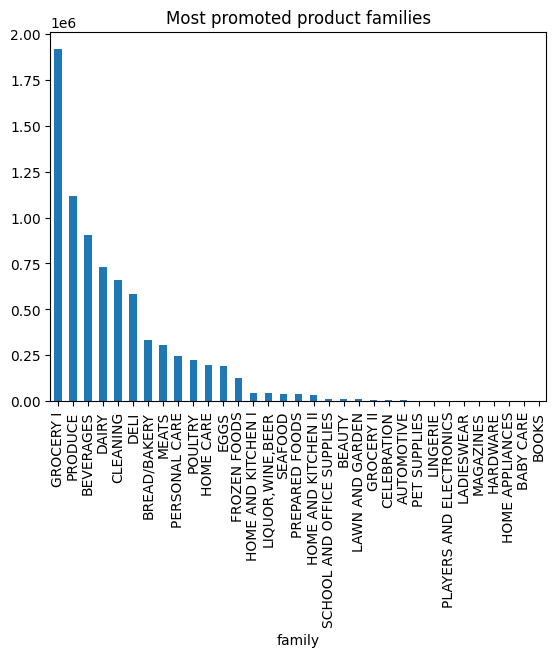

In [369]:
# Most promoted product family?
promoted_families = store_sales.groupby("family")["onpromotion"].sum().sort_values(ascending=False)
promoted_families.plot(kind="bar", title="Most promoted product families");

The plot above shows the most promoted product families sorted in descending order

Observing the plot shows that `GROCERY I` is the most promoted product familiy all time. It's also interesting to see `GRCOERY II` at the lower end of the spectrum.

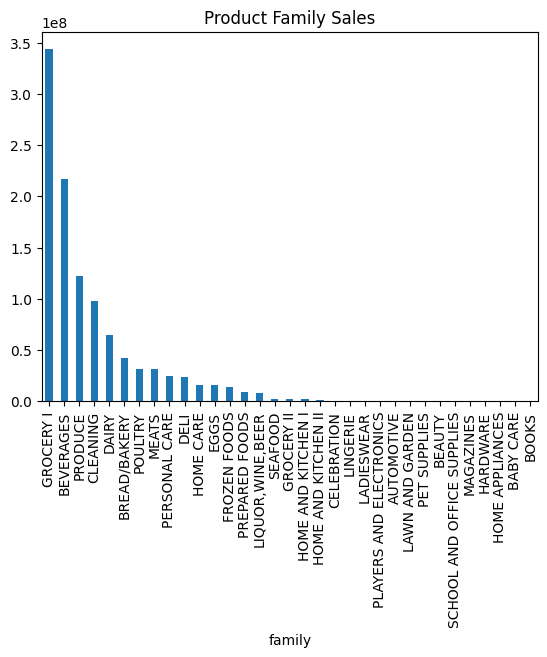

In [370]:
# Product families making the most sales
family_sales = store_sales.groupby("family")["sales"].sum().sort_values(ascending=False)
family_sales.plot(kind="bar", title="Product Family Sales");

The plot above shows the total sales by each product family sorted in descending order

Observing the plot shows that `GROCERY I` still ranks first here, with `GROCERY II` at a similar position and `BOOKS` ranking last. This indicates some correlation. Let's check the correlaction between these two  variables.

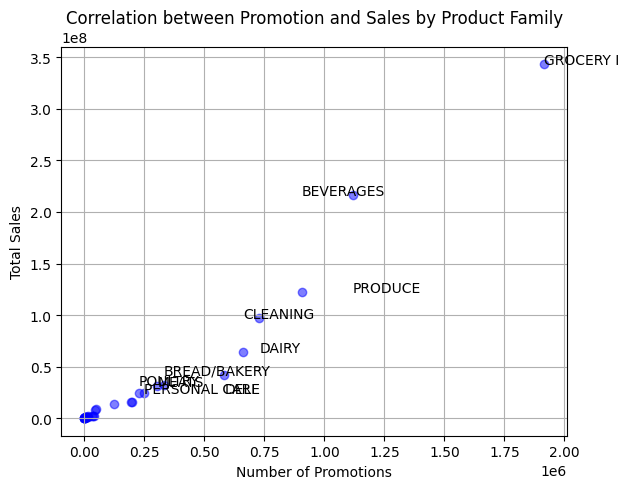

In [371]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_families, family_sales, color='b', alpha=0.5)
plt.title('Correlation between Promotion and Sales by Product Family')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_families[:10].index:
    plt.annotate(family_name, (promoted_families[family_name], family_sales[family_name]))

plt.show()

The correlation plot between Promotion and Sales by Product family is positive. 

One can make an assumption that the amount of promotions is a key factor to how much sales a product family makes at Favorita.

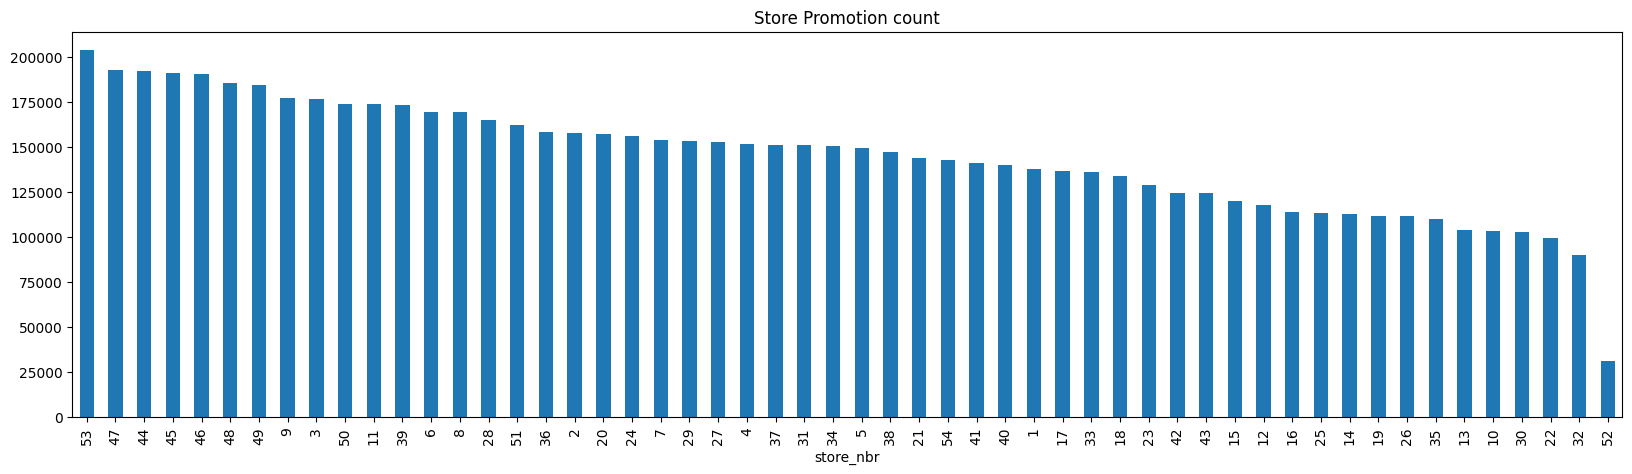

In [372]:
# Most promoted stores
promoted_stores = store_sales.groupby("store_nbr")["onpromotion"].sum().sort_values(ascending=False)
promoted_stores.plot(kind="bar", figsize=(20,5), title="Store Promotion count");

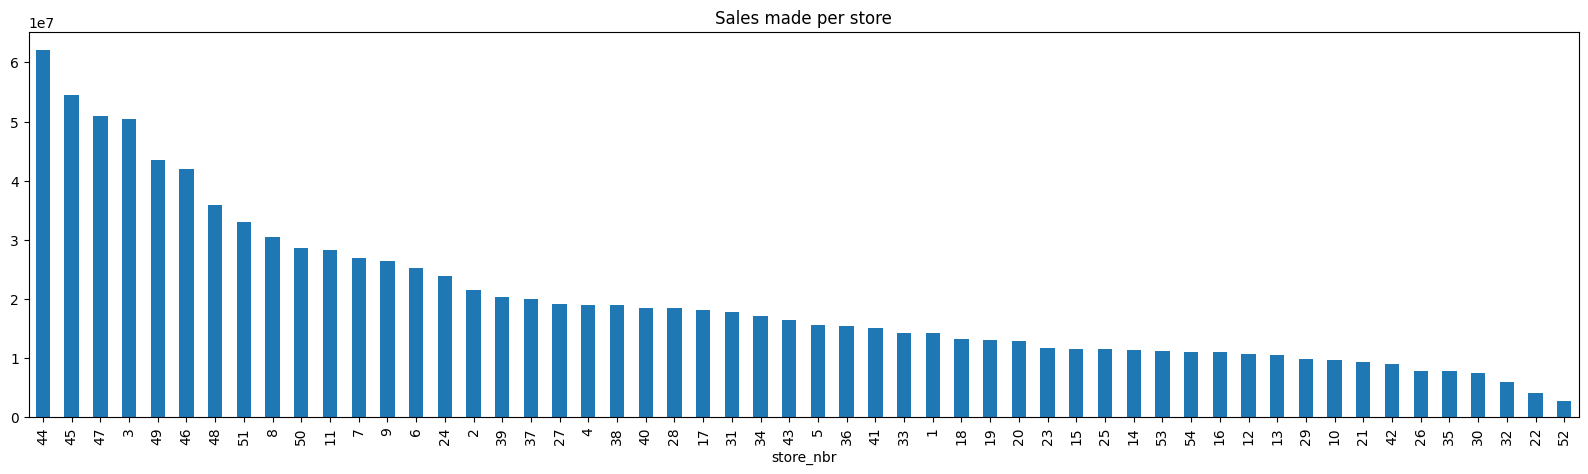

In [373]:
# Sales made by each store
sales_by_store = store_sales.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)
sales_by_store.plot(kind="bar", figsize=(20,5), title="Sales made per store");

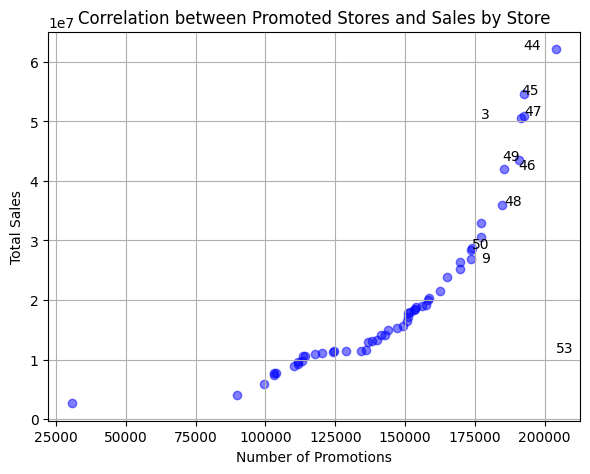

In [374]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_stores, sales_by_store, color='b', alpha=0.5)
plt.title('Correlation between Promoted Stores and Sales by Store')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_stores[:10].index:
    plt.annotate(family_name, (promoted_stores[family_name], sales_by_store[family_name]))

plt.show()

The correlation plot between Promoted Stores and Sales by Store is also positive. 

Like before, one can also make an assumption that the amount of promotions are a key factor to how much sales are made by a Favorita store.

**Store Sales: Data Hierarchy**

The dataset is a time series of the product family sales for each of the favorita stores at every given day.

In [ ]:
# rearrange dataset to display it's hierarchical nature
# storesales_reindexed = store_sales.groupby(['store_nbr', 'family', 'date']).mean()
# storesales_reindexed[:40]

### Analysis on `store_sales`:

**Columns**:
- *store_nbr* - identifies the 54 different stores at which the products are being sold at.
- *family* - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- *onpromotion* - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- *sales (target)* - describes the total sales per product family at a given store on a given date.
  
**Index columns**: 
- date
- store_nbr
- family

**Rows**

* Rows highlight measurement at that "date", in store with "store_nbr", for product family "family"

**Observations**

* there are 3.000.887 rows in total
* there are 33 distinct product families (family) in total, such as AUTOMOTIV, POULTRY
* there are 54 store_nbr in total, ranging over all integers from 1 to 54. They have the same 33 distinct product families
* there are 765 distinct dates in total, ranging from 2013-01-01 to 2017-08-15 (5+ years)
* There is a positive correlation between the Promoted product families and families making the most sales. There is also a positive correlation between the Promoted stores and stores making the most sales. These highlights the promotions has a significant on Favorita's sales.

## 2. `future_sales`

Dataset: **test.csv**

* The test data, having the same features as the training data.
* The dates in the test data are for the 15 days after the last date in the training data (`store_sales`)
* Target sales for the dates are to be predicted.


In [376]:
future_sales = pd.read_csv(
    './data/test.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [377]:
future_sales

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

## 3. `store_metadata`

Dataset: **stores.csv**

Store metadata, including

- *city*, 
- *state*, 
- *type*
- *cluster*: a grouping of similar stores.

In [378]:
store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

In [379]:
store_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), int64(1)
memory usage: 3.0 KB


In [380]:
# Check for missing values
store_metadata.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [381]:
store_metadata.head()

store_nbr           city                           state type cluster
0          1          Quito                       Pichincha    D      13
1          2          Quito                       Pichincha    D      13
2          3          Quito                       Pichincha    D       8
3          4          Quito                       Pichincha    D       9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D       4

In [382]:
# Number of unique enteries
store_metadata.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

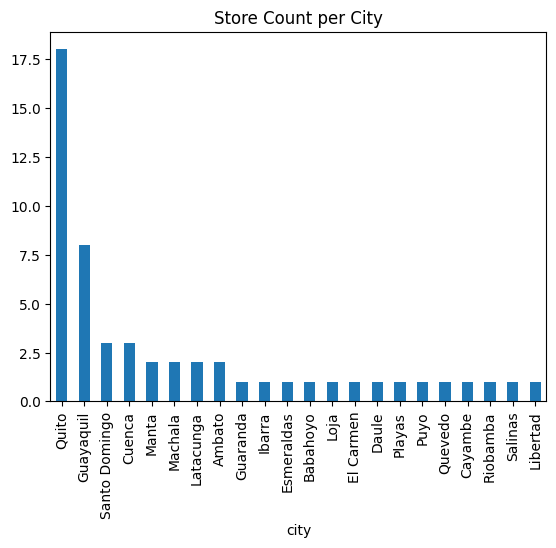

In [383]:
# Number of stores in each city
store_city_count = store_metadata.groupby(['city']).store_nbr.nunique().sort_values(ascending=False)
store_city_count.plot(kind="bar", title="Store Count per City");

The Store Count per city plot shows `Quito` ranks 1st place with a total of 18 stores. 

This is highly reasonable as Quito is the Capital city of Ecuador and according to [Wikipedia](https://en.wikipedia.org/wiki/Ecuador#Largest_cities), is the largest city in the country with 2.78 inhabitants. 

`Guayaquil`, the second largest city with 2.72 million inhabitants appears second in the store count plot with a total of 8 stores. 

Other highly populated cities appear at the high end of the scale and vice-versa

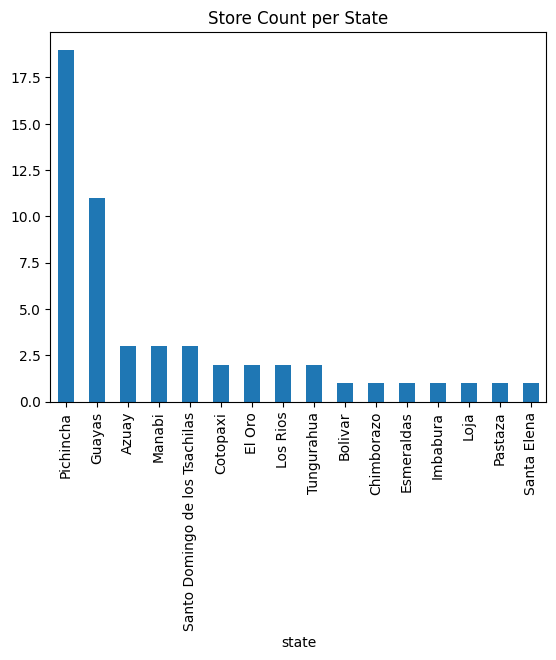

In [384]:
# Number of stores in each state
store_state_count = store_metadata.groupby(['state']).store_nbr.nunique().sort_values(ascending=False)
store_state_count.plot(kind="bar", title="Store Count per State");


Wikipedia mentions `Quito` is also the capital of the Province of `Pichincha` which largely explains it's rank. 

`Guayas` is the Province of `Guayaquil` which also comes second place here.

The overview informs us that `cluster` is a grouping of similar stores

In [385]:
store_metadata.sort_values(by="cluster")

store_nbr           city                           state type cluster
26         27          Daule                          Guayas    D       1
24         25        Salinas                     Santa Elena    D       1
23         24      Guayaquil                          Guayas    D       1
42         43     Esmeraldas                      Esmeraldas    E      10
35         36       Libertad                          Guayas    E      10
30         31       Babahoyo                        Los Rios    B      10
28         29      Guayaquil                          Guayas    E      10
27         28      Guayaquil                          Guayas    E      10
25         26      Guayaquil                          Guayas    D      10
51         52          Manta                          Manabi    A      11
48         49          Quito                       Pichincha    A      11
44         45          Quito                       Pichincha    A      11
16         17          Quito                       Pichincha    C      12
52         53          Manta                          Manabi    D      13
0           1          Quito                       Pichincha    D      13
1           2          Quito                       Pichincha    D      13
5           6          Quito                       Pichincha    D      13
45         46          Quito                       Pichincha    A      14
49         50         Ambato                      Tungurahua    A      14
47         48          Quito                       Pichincha    A      14
46         47          Quito                       Pichincha    A      14
12         13      Latacunga                        Cotopaxi    C      15
9          10          Quito                       Pichincha    C      15
11         12      Latacunga                        Cotopaxi    C      15
14         15         Ibarra                        Imbabura    C      15
18         19       Guaranda                         Bolivar    C      15
17         18          Quito                       Pichincha    B      16
50         51      Guayaquil                          Guayas    A      17
41         42         Cuenca                           Azuay    D       2
36         37         Cuenca                           Azuay    D       2
39         40        Machala                          El Oro    C       3
15         16  Santo Domingo  Santo Domingo de los Tsachilas    C       3
34         35         Playas                          Guayas    C       3
53         54      El Carmen                          Manabi    C       3
31         32      Guayaquil                          Guayas    C       3
32         33        Quevedo                        Los Rios    C       3
29         30      Guayaquil                          Guayas    C       3
37         38           Loja                            Loja    D       4
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D       4
40         41        Machala                          El Oro    D       4
43         44          Quito                       Pichincha    A       5
8           9          Quito                       Pichincha    B       6
38         39         Cuenca                           Azuay    B       6
10         11        Cayambe                       Pichincha    B       6
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B       6
19         20          Quito                       Pichincha    B       6
33         34      Guayaquil                          Guayas    B       6
21         22           Puyo                         Pastaza    C       7
13         14       Riobamba                      Chimborazo    C       7
6           7          Quito                       Pichincha    D       8
2           3          Quito                       Pichincha    D       8
7           8          Quito                       Pichincha    D       8
3           4          Quito                       Pichincha    D       9
22      

In [386]:
# View stores in each cluster
store_cluster_items = store_metadata.groupby("cluster").store_nbr.unique()
store_cluster_items

cluster
1                     [24, 25, 27]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 6, 53]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [5, 38, 41]
5                             [44]
6          [9, 11, 20, 21, 34, 39]
7                         [14, 22]
8                        [3, 7, 8]
9                          [4, 23]
Name: store_nbr, dtype: object

In [387]:
store_cluster_items[0]

array([24, 25, 27], dtype=int64)

In [388]:
# Examine stores in cluster n

n="16"
store_metadata[store_metadata["store_nbr"].isin(store_cluster_items[n])]

store_nbr   city      state type cluster
17         18  Quito  Pichincha    B      16

In [389]:
# Function for plotting cluster and type clusters
def plot_cluster_average(df, cluster_items, plot_df=None, window=7, title="N/A", remove_legend=False, legend_loc=None):
    rows = 6
    cols = 3
    fig, axes = plt.subplots(rows,cols,figsize=(30,10))

    k=0
    for i in range(rows):
        for j in range(cols):
            df1 = df[df["store_nbr"].isin(cluster_items[k])]
            df1 = df1.groupby('date')['sales'].mean()

            plot_df = df1
            
            moving_average = df1.rolling(
              window=window,
              center=True,
              min_periods=window//2).mean()
            
            plot_df.plot(style=".", color="0.5", ax=axes[i,j])
            moving_average.plot(
              ax=axes[i,j], linewidth=3, title=f"Cluster {k} {window}-Day Moving Average", legend=False)
            
            if remove_legend:
                try:
                  ax.get_legend().remove()
                except:
                  pass
            
            # Use a single Legend
            if legend_loc:
              handles, labels = axes[-1].get_legend_handles_labels()
              fig.legend(handles, labels, loc=legend_loc);
            
            k+=1
            if k>=len(cluster_items): break
        if k>=len(cluster_items): break

In [390]:
store_cluster_items

cluster
1                     [24, 25, 27]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 6, 53]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [5, 38, 41]
5                             [44]
6          [9, 11, 20, 21, 34, 39]
7                         [14, 22]
8                        [3, 7, 8]
9                          [4, 23]
Name: store_nbr, dtype: object

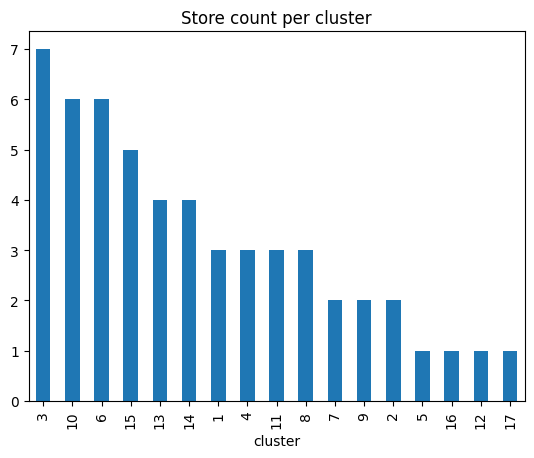

In [391]:
cluster_count = store_metadata.groupby("cluster").store_nbr.nunique().sort_values(ascending=False)
cluster_count.plot(kind="bar", title="Store count per cluster");

In [392]:
store_metadata.groupby("cluster").store_nbr.unique()

cluster
1                     [24, 25, 27]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 6, 53]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [5, 38, 41]
5                             [44]
6          [9, 11, 20, 21, 34, 39]
7                         [14, 22]
8                        [3, 7, 8]
9                          [4, 23]
Name: store_nbr, dtype: object

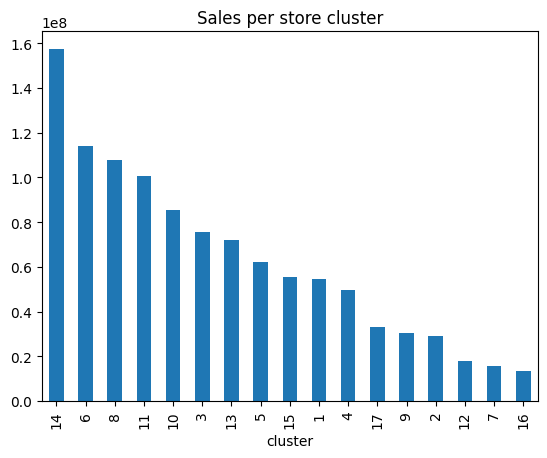

In [393]:
# Sales made by each store cluster
store_cluster_sales = store_sales_merged.groupby(["cluster"])['sales'].sum().sort_values(ascending=False)
store_cluster_sales.plot(kind="bar", title="Sales per store cluster");

In [394]:
# Use this to group cluster plot by most sales
store_clustersales_index = [i for i in store_cluster_sales.index]
store_clustersales_index

['14',
 '6',
 '8',
 '11',
 '10',
 '3',
 '13',
 '5',
 '15',
 '1',
 '4',
 '17',
 '9',
 '2',
 '12',
 '7',
 '16']

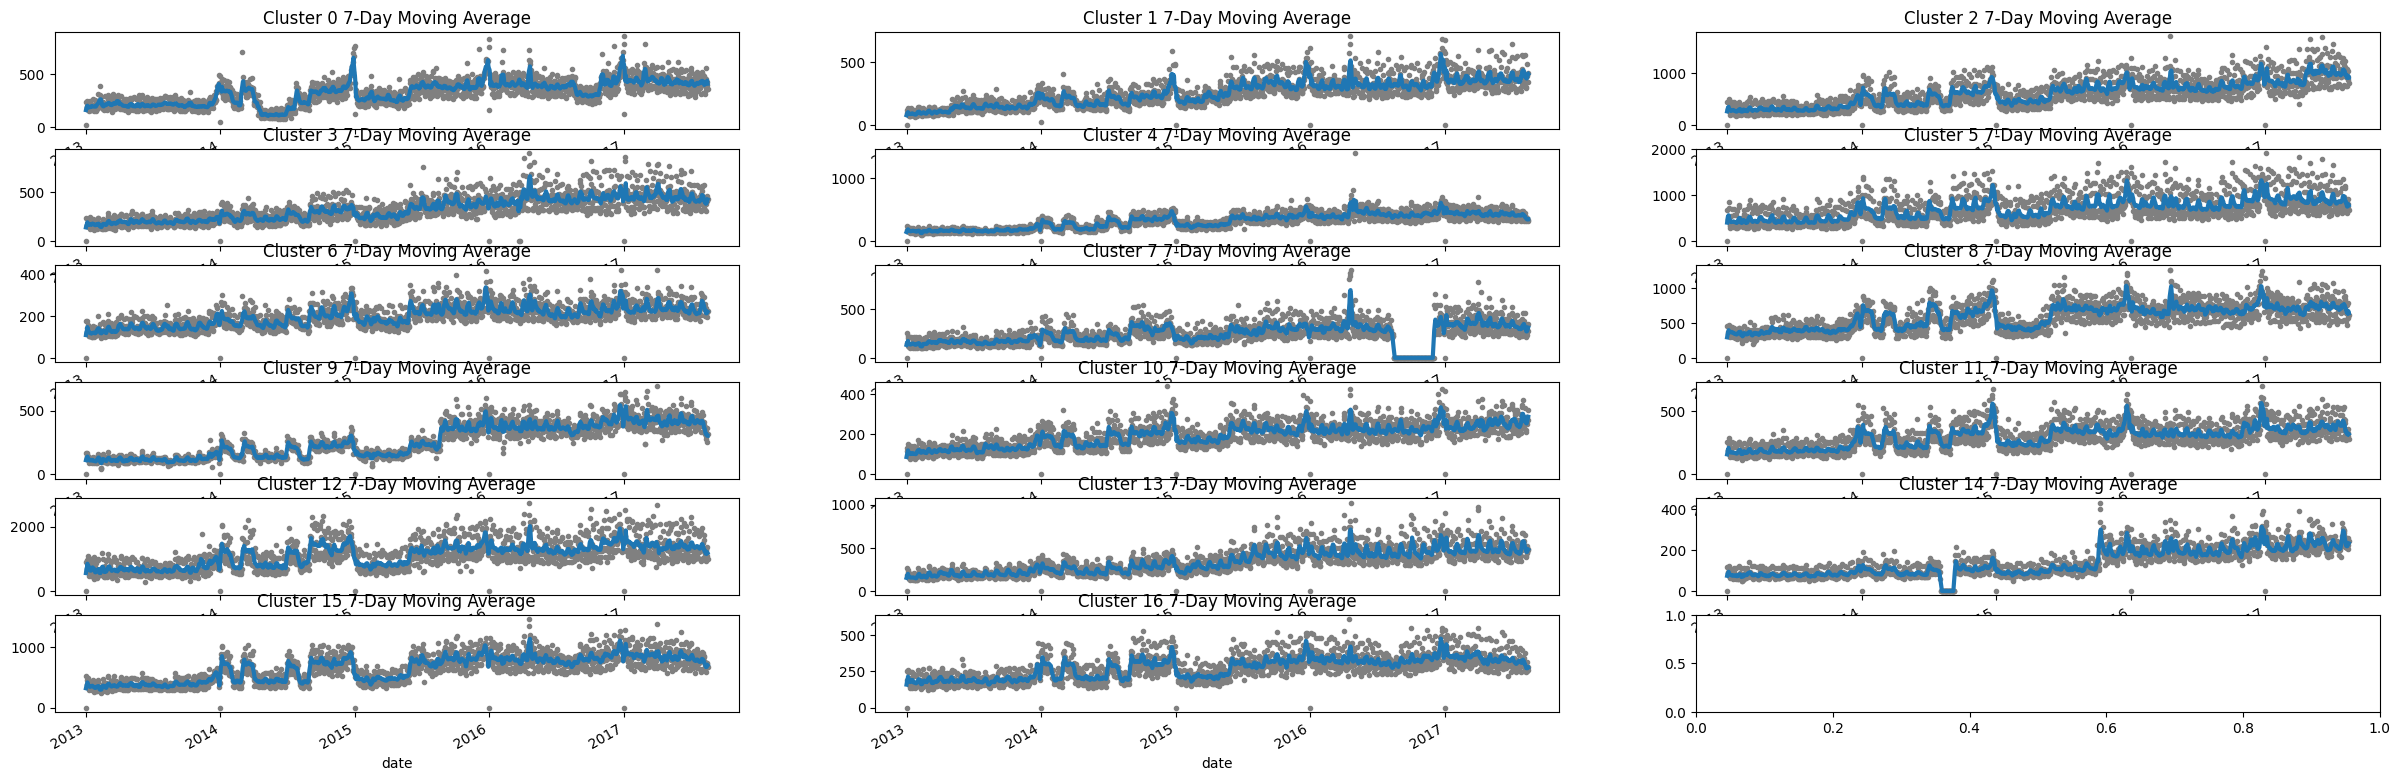

In [395]:
# cluster_daily_average_sales = cluster_sales.groupby('date')['sales'].mean()
plot_cluster_average(store_sales, store_cluster_items)

In [396]:
type_cluster_items

NameError: name 'type_cluster_items' is not defined

In [ ]:
type_cluster_items = store_metadata.groupby("type").store_nbr.unique()
plot_cluster_average(store_sales, type_cluster_items)

Observations

Playing around with the various clusters 

Stores with missing dates are in clusters
Different store clusters have different trends (different line curvatures), perhaps estimators can be trained on different cluster datasets?

e.g. New data comes in -> identify cluster -> do prediction etc.

Maybe do a trend plot for all clusters in a single plot to higlight this. Instead of splitting the moving average into 4.

In [ ]:
# store_sales_merged creation is actually done later in this notebook

store_sales_merged.groupby('cluster')['sales'].describe()

In [ ]:
# View unique store type
store_cluster_items = store_metadata.groupby("type").cluster.unique()
store_cluster_items

In [ ]:
# Does each cluster have a unique store type?

store_sales_merged.groupby('cluster')['type'].nunique()

In [ ]:
# Examine cluster 10 without a unique type

n="10"
store_metadata[store_metadata["cluster"]=="10"]

### Feature Enrichment

Merging more columns to the main `store_sales` dataframe

In [397]:
# dates information
store_sales_merged = store_sales.copy()
store_sales[:1].date.dt.year

0    2013
Name: date, dtype: int32

In [398]:
store_sales_merged["saleYear"] = store_sales_merged.date.dt.year
store_sales_merged["saleMonth"] = store_sales_merged.date.dt.month
store_sales_merged["saleDay"] = store_sales_merged.date.dt.day
store_sales_merged["saleDayOfWeek"] = store_sales_merged.date.dt.dayofweek
store_sales_merged["saleDayOfYear"] = store_sales_merged.date.dt.dayofyear

In [399]:
store_sales_merged.head()

id       date  store_nbr      family  sales  onpromotion  saleYear  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0      2013   
1   1 2013-01-01          1   BABY CARE    0.0            0      2013   
2   2 2013-01-01          1      BEAUTY    0.0            0      2013   
3   3 2013-01-01          1   BEVERAGES    0.0            0      2013   
4   4 2013-01-01          1       BOOKS    0.0            0      2013   

   saleMonth  saleDay  saleDayOfWeek  saleDayOfYear  
0          1        1              1              1  
1          1        1              1              1  
2          1        1              1              1  
3          1        1              1              1  
4          1        1              1              1

In [400]:
# Merge type into store sales dataframe
store_sales_merged = pd.merge(store_sales_merged, store_metadata[['store_nbr', 'type', 'cluster']], on='store_nbr', how='left')

In [401]:
store_sales_merged

id       date  store_nbr                      family  \
0              0 2013-01-01          1                  AUTOMOTIVE   
1              1 2013-01-01          1                   BABY CARE   
2              2 2013-01-01          1                      BEAUTY   
3              3 2013-01-01          1                   BEVERAGES   
4              4 2013-01-01          1                       BOOKS   
...          ...        ...        ...                         ...   
3000883  3000883 2017-08-15          9                     POULTRY   
3000884  3000884 2017-08-15          9              PREPARED FOODS   
3000885  3000885 2017-08-15          9                     PRODUCE   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   
3000887  3000887 2017-08-15          9                     SEAFOOD   

               sales  onpromotion  saleYear  saleMonth  saleDay  \
0           0.000000            0      2013          1        1   
1           0.000000            0      2013          1        1   
2           0.000000            0      2013          1        1   
3           0.000000            0      2013          1        1   
4           0.000000            0      2013          1        1   
...              ...          ...       ...        ...      ...   
3000883   438.132996            0      2017          8       15   
3000884   154.552994            1      2017          8       15   
3000885  2419.729004          148      2017          8       15   
3000886   121.000000            8      2017          8       15   
3000887    16.000000            0      2017          8       15   

         saleDayOfWeek  saleDayOfYear type cluster  
0                    1              1    D      13  
1                    1              1    D      13  
2                    1              1    D      13  
3                    1              1    D      13  
4                    1              1    D      13  
...                ...            ...  ...     ...  
3000883              1            227    B       6  
3000884              1            227    B       6  
3000885              1            227    B       6  
3000886              1            227    B       6  
3000887              1            227    B       6  

[3000888 rows x 13 columns]

In [402]:
store_sales_merged.to_csv("store_clean.csv")

# Hierarchical Time-Series

A hierarchical Time-Series is a any collection of time-series that follows a hierarchical aggregation structure. From this definition, we can see we are clearly working with Hierarchical time-series data.

**Hierarchies**

* Store Hierarchy: We can show this hierarchy by splitting our store sales data into the individual store time-series and viewing their trend.

In [433]:
# interpolate missing values
store_sales['sales'].interpolate(method='linear', inplace=True)
store_sales['sales'].ffill(inplace=True)
store_sales['sales'].bfill(inplace=True)

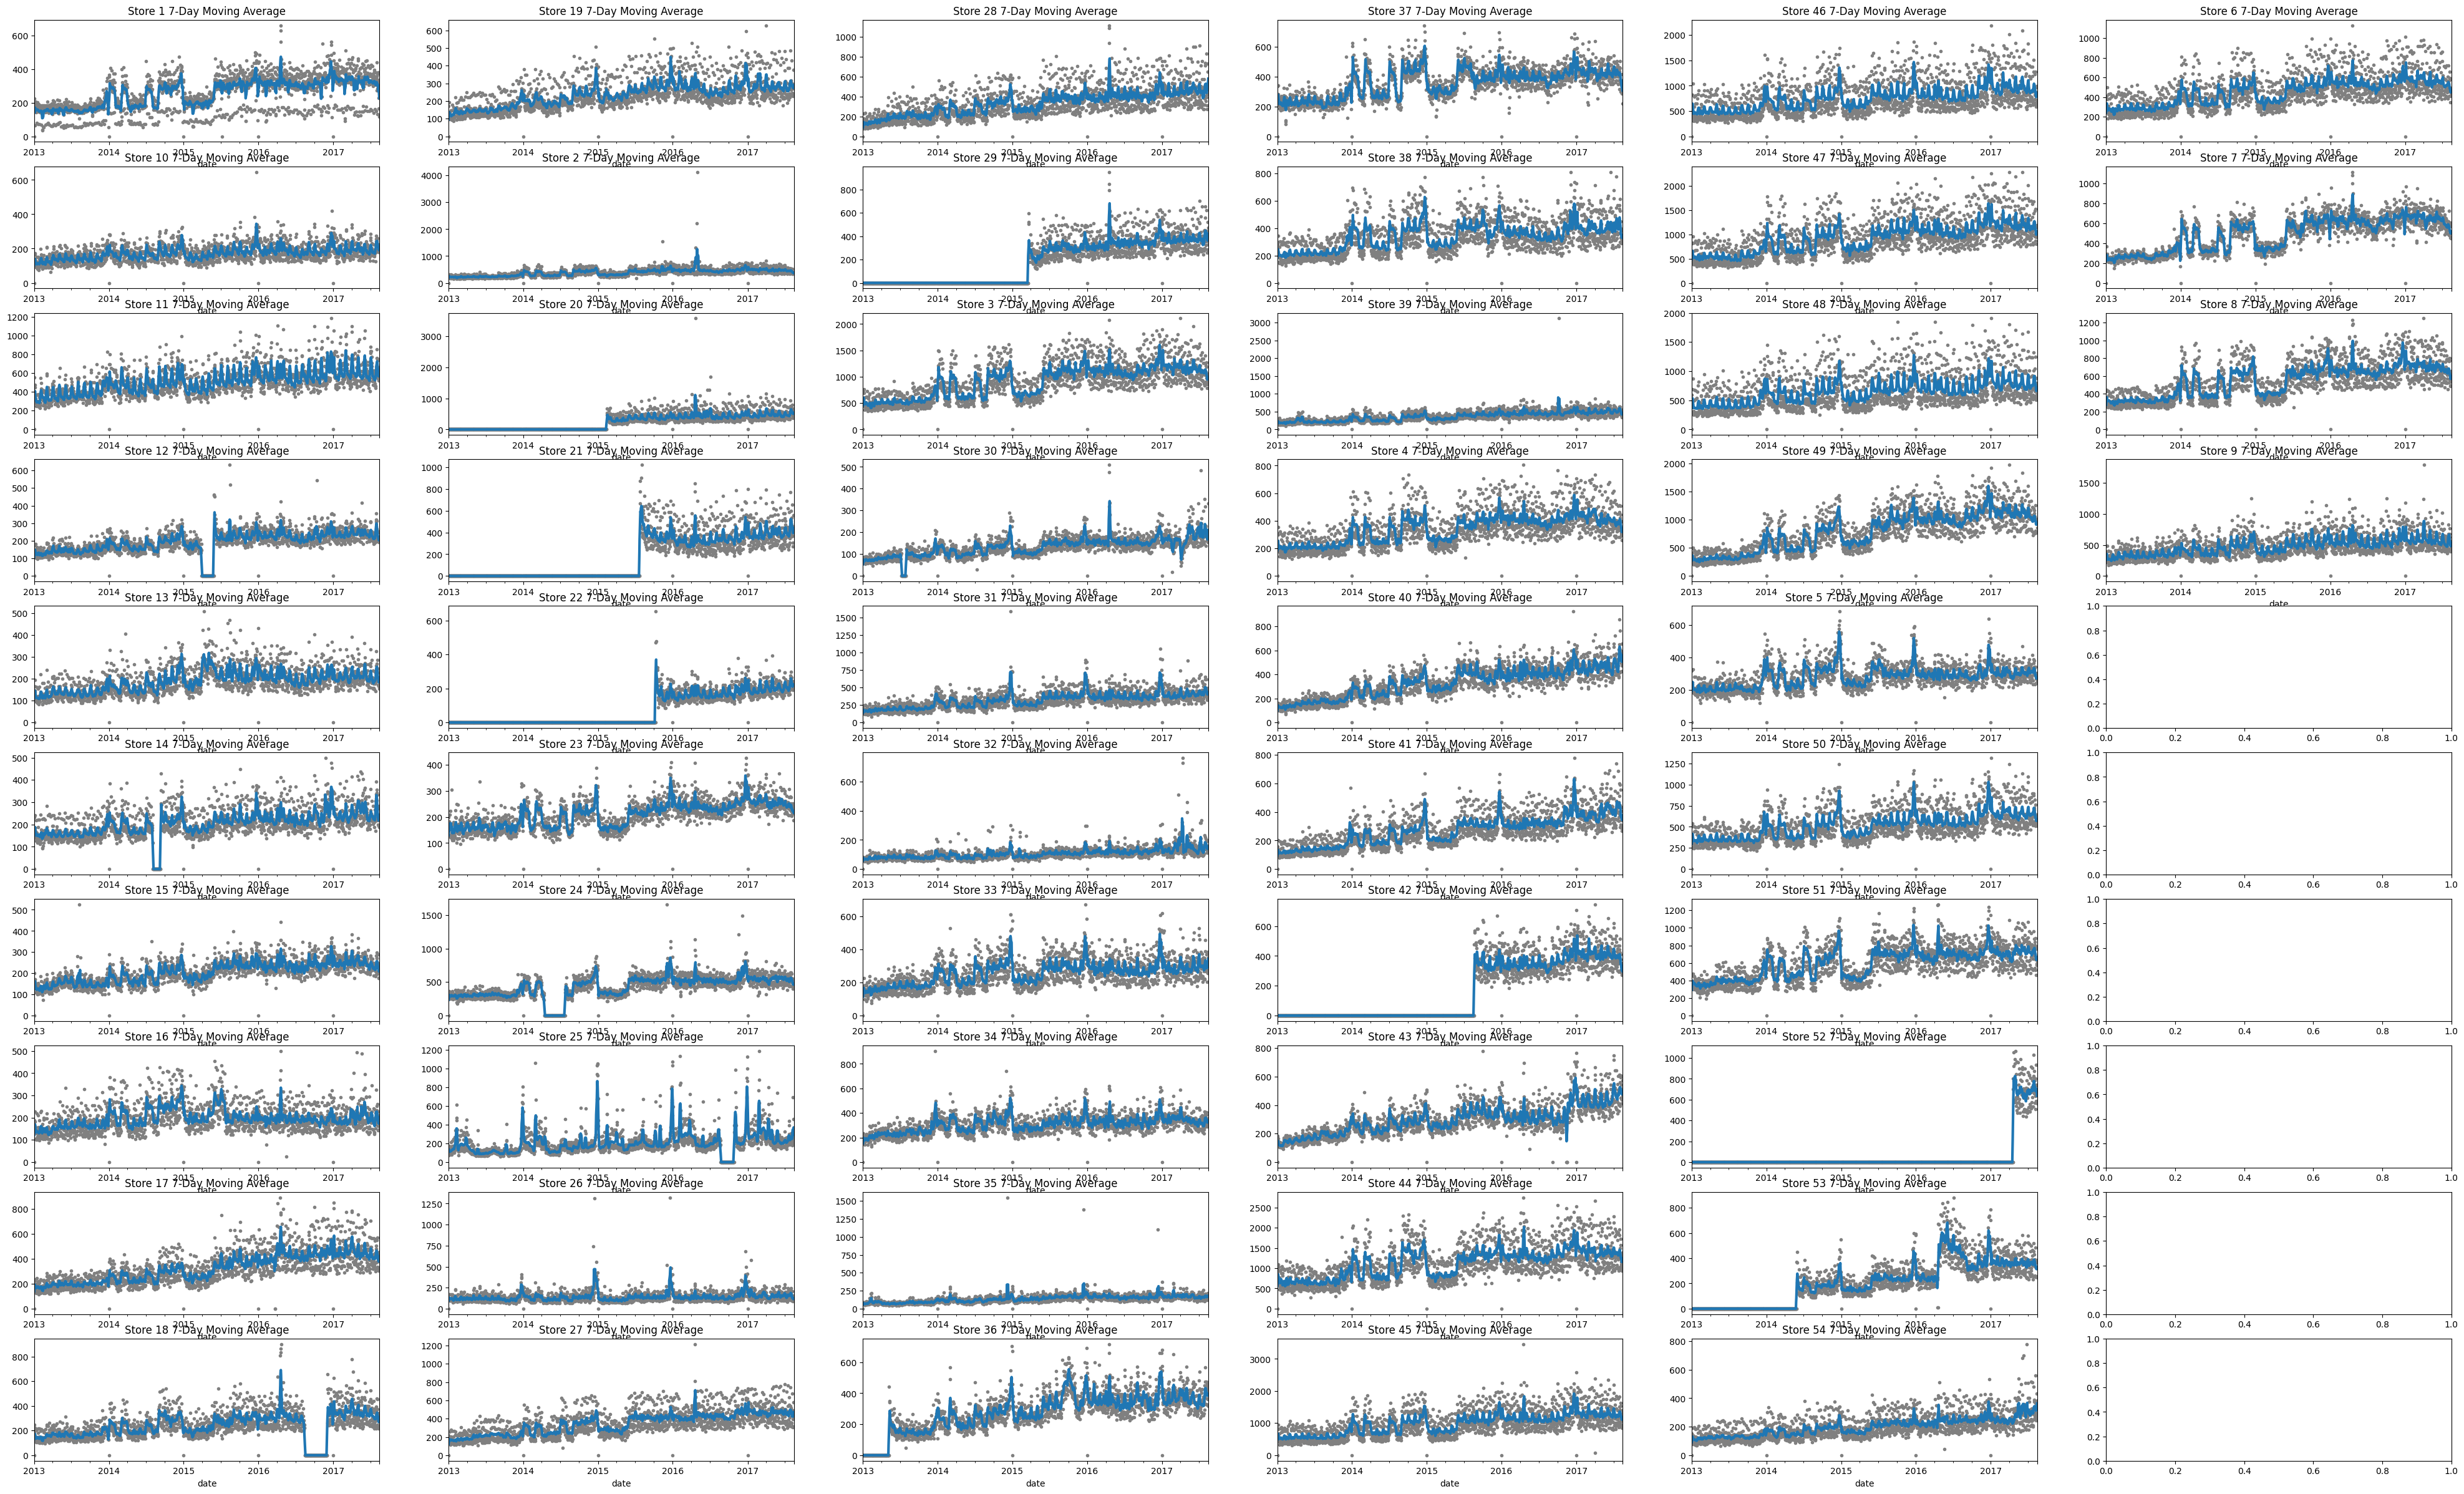

In [434]:
rows = 10
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(50,30))

i = 0
j = 0
for nbr in store_sales['store_nbr'].unique():
    df1 = store_sales[store_sales["store_nbr"]==nbr].groupby("date")['sales'].mean()

    window=7
    moving_average = df1.rolling(
        window=window,
        center=True,
        min_periods=window//2
    ).mean()
    
    df1.plot(style=".", color="0.5", ax=axes[i, j])
    moving_average.plot(linewidth=3, title=f"Store {nbr} {window}-Day Moving Average", legend=False, ax=axes[i, j]
    )
    i+=1
    if i >= rows:
        i = 0
        j+=1


* Product Hierarchy: This store-hierarcy can still be broken down to individual product time-series. Again, we use the p

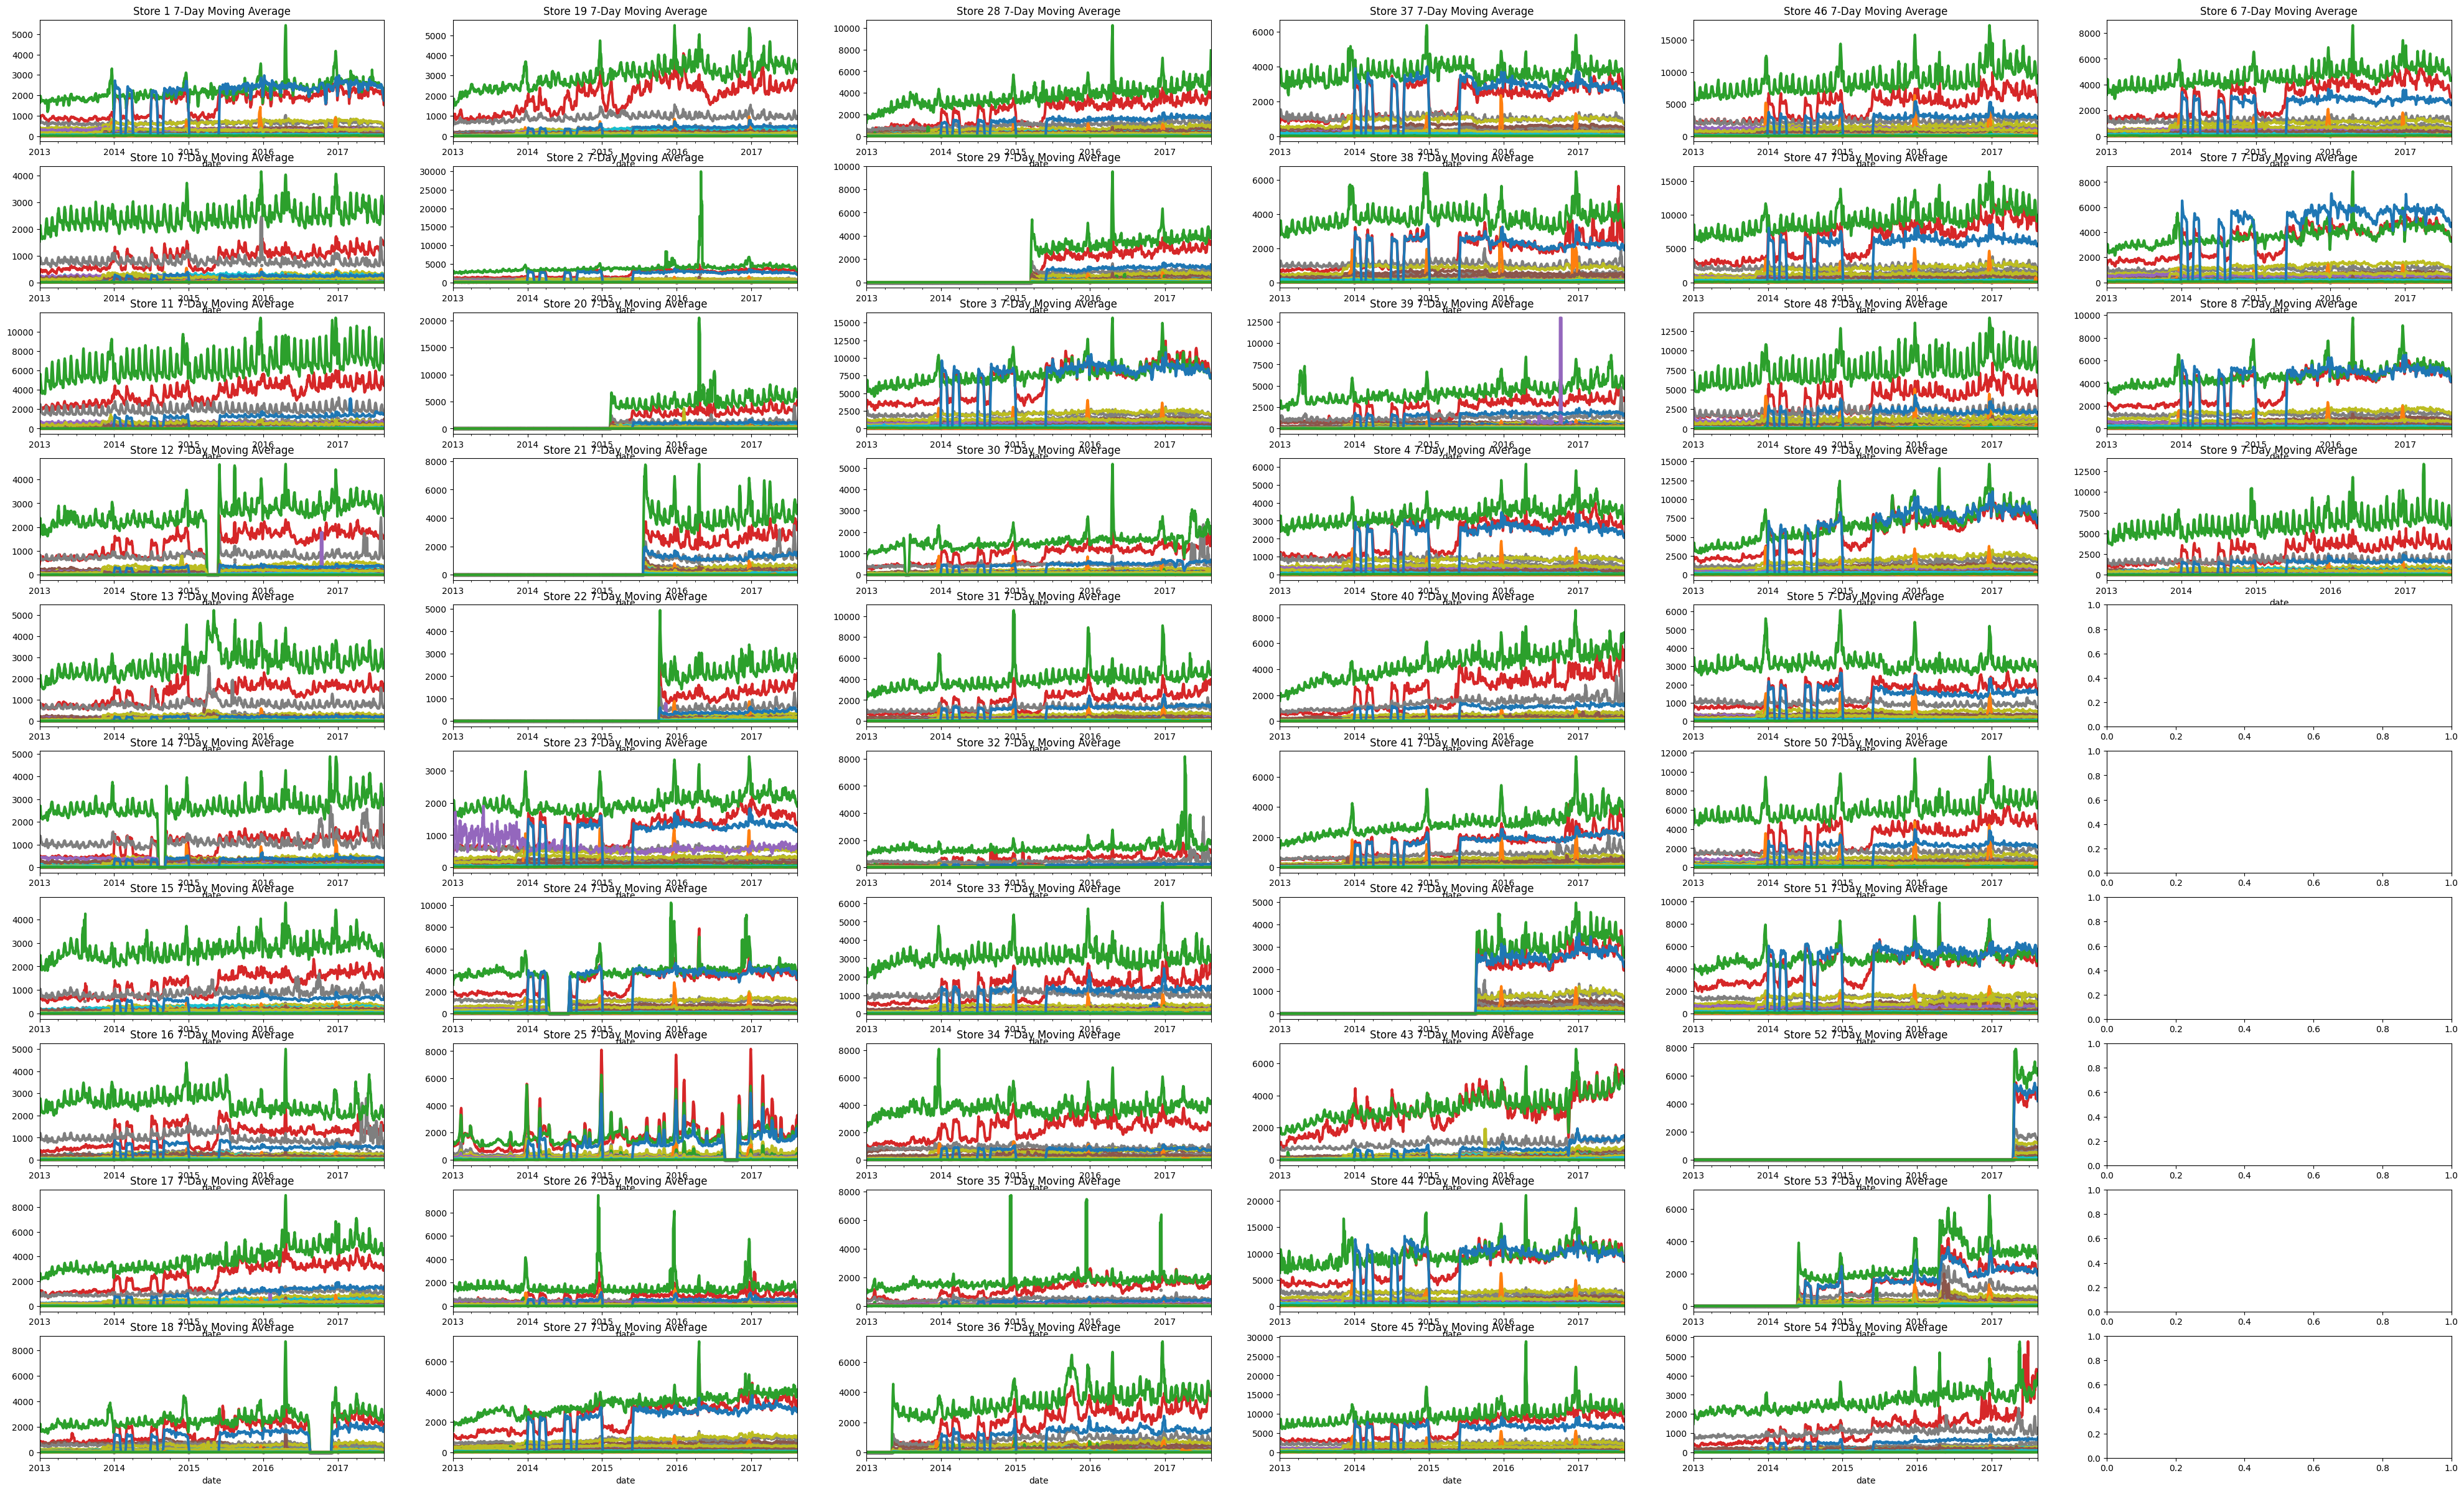

In [435]:
rows = 10
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(50,30))

i = 0
j = 0
for nbr in store_sales['store_nbr'].unique():
    df1 = store_sales[store_sales["store_nbr"]==nbr].groupby(['date', 'family'])['sales'].mean().reset_index()
    df1 = df1.pivot(index='date', columns='family', values='sales')

    window=7
    moving_average = df1.rolling(
        window=window,
        center=True,
        min_periods=window//2
    ).mean()
    
    plot_df = store_sales[store_sales["store_nbr"]==nbr].groupby("date")['sales'].mean()
    plot_df.plot(style=".", color="0.5", ax=axes[i, j])
    moving_average.plot(linewidth=3, title=f"Store {nbr} {window}-Day Moving Average", legend=False, ax=axes[i, j]
    )
    i+=1
    if i >= rows:
        i = 0
        j+=1


# Others

## 4. `holidays_events` 

Dataset: **holidays_events.csv**

Holidays and Events, with metadata.

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [436]:
holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

## 5. `transactions`: 

Notes: Separate for now

In [437]:
transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [438]:
transactions

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

## 6. `daily_oil_price`

Dataset: **oil.csv**

Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

* Includes daily oil price. 
* Includes values during both the train and test data timeframes.

Notes: Can be used later as exogenous

In [439]:
daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

# daily_oil_price.info()

# Modelling

## Without exogeneous data

In [ ]:
store_sales["date"] = store_sales["date"].dt.to_period('D')

In [442]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(store_sales, test_size=0.1, train_size=0.9, shuffle=False)

In [443]:
y_train = y_train.groupby(['store_nbr', 'family', 'date']).mean()["sales"].to_frame()
y_test = y_test.groupby(['store_nbr', 'family', 'date']).mean()["sales"].to_frame()

In [444]:
y_train

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0
...                                ...
54        SEAFOOD    2017-02-24    2.0
                     2017-02-25    1.0
                     2017-02-26    2.0
                     2017-02-27    5.0
                     2017-02-28    NaN

[2701512 rows x 1 columns]

In [445]:
y_test

sales
store_nbr family     date             
1         AUTOMOTIVE 2017-02-28    NaN
                     2017-03-01    1.0
                     2017-03-02    3.0
                     2017-03-03    5.0
                     2017-03-04    6.0
...                                ...
54        SEAFOOD    2017-08-11    0.0
                     2017-08-12    1.0
                     2017-08-13    2.0
                     2017-08-14    0.0
                     2017-08-15    3.0

[301158 rows x 1 columns]

In [446]:
## exp smoothing requires non-zero values
# y = y+0.00001 # add epsilon
# y

In [447]:
# from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# forecaster = ExponentialSmoothing(
#     trend='add', seasonal='multiplicative', sp=12
# )  
# forecaster.fit(y)  
# y_pred = forecaster.predict(fh=[1,2,3])
# y_pred

In [ ]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA()

y_pred = forecaster.fit(y_train, fh=[1]).predict(y_test, fh=[1])
y_pred

In [ ]:
from sktime.utils.plotting import plot_series
ins=("1","AUTOMOTIVE")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

In [ ]:
# bottom-up reconcilation
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.hierarchical.aggregate import Aggregator

pipeline_to_forecast_totals = NaiveForecaster() * Aggregator()

pipeline_to_forecast_totals.fit(y_train, fh=[1])
pipeline_to_forecast_totals.predict()

In [ ]:
# Reconciler - transformer-like reconciliation
from sktime.transformations.hierarchical.reconcile import Reconciler

pipeline_with_reconciliation = (
    Aggregator() * NaiveForecaster() * Reconciler(method="ols")
)

In [ ]:
pipeline_to_forecast_totals.fit(y_train, fh=[1])
pipeline_to_forecast_totals.predict()

In [ ]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 10,  # for quick test
    },
)

y_pred = model.predict(y=y_test, fh=fh)
y_pred


# Evaluation

# Submission